# Notebook 4

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/04_notebook/glacier-modelling-4.ipynb) and you will donwload the repo  below. Make sure to activate the GPU on Colab "Runtime" -> "Change Runtime Type" -> Slect GPU.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

## How to install IGM?

Running IGM consists of running a python script `igm_run`, which is made of functions of the `igm` python package.  First of all, one needs to install igm as follows: (this may take a while, and it may crashes the first time, but should work the second time).

In [15]:
! pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple igm-model-testing-package==3.0.5
! pip install ml-dtypes==0.5.3

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.79 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.17.1 which is incompatible.
jax 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatibl

## Download the data

Let's now download the repo with the data if you are using Colab

In [52]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
    !apt-get install tree -q
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
fatal: destination path 'glamod' already exists and is not an empty directory.
Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Let's now go the working folder

In [53]:
if "google.colab" in sys.modules:
    %cd /content/glamod/04_notebook

/content/glamod/04_notebook



# Modelling Glacier du Mont Miné

In this notebook we aim to model the evolution of "[Glacier du Mont Miné](https://www.google.com/maps/place/Mont+Min%C3%A9+Glacier/@46.0145075,7.4877889,24811m/data=!3m1!1e3!4m6!3m5!1s0x478f2db4b5d1a731:0x2c7d28e4d7f7bb26!8m2!3d46.014!4d7.54439!16s%2Fm%2F04n61lb?entry=ttu&g_ep=EgoyMDI0MTAyNy4wIKXMDSoASAFQAw%3D%3D,)" located in te South of Sion (Valais, Switzerland), from the end of the little ice age (about 1850) to now, the goal being to calibrate the glacier model to match the OSL data. To this aim, we take over the material from the previous notebook, and apply it Mont Miné.

You may find on slides 28 to 30 some graphical [illustrations](https://www.unige.ch/forel/application/files/3116/5476/6042/F-Evolene-Paysagesglaciaires_compressed.pdf) of the retreat of the Mont Miné Glacier since the end of the Little Ice Age (LIA).



Running `igm_run +experiment=params` will  collect the data, run the model forward in time from 1700 to 2024 with a rather simple surface mass balance parametrized by the equilibrium line altitude, and save the output in a netCDF file `output.nc`.

In [54]:
! igm_run +experiment=params

2025-12-02 10:00:19.283912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 10:00:19.303743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 10:00:19.309767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 10:00:19.324383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 10:00:22.091006: W tensorflow/comp

Explore `params.yaml` to see the details of the configuration. A closer look at the parameter file shows that we declare some physical modules, such as `smb_simple`, `iceflow`, `time`, and `thk`.

The first module `smb_simple` computes the surface mass balance as $SMB(z) = \alpha (z - z_{ELA})$, with one SMB gradient $\beta_{abl}$ in the ablation area when $z < z_{ELA}$, and one SMB gradient $\beta_{acc}$ in the accumulation area when $z > z_{ELA}$, along with a maximum SMB capping value of $a_{max}$, as illustrated in the following figure:

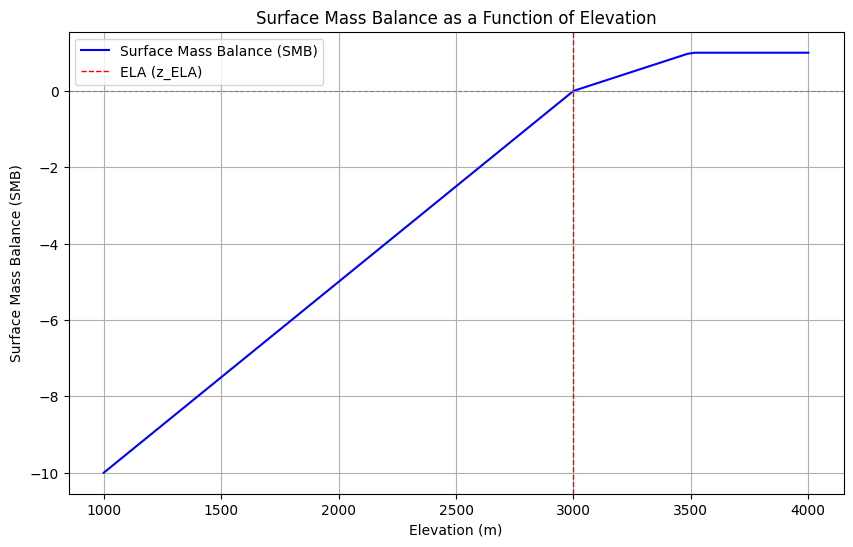

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def surface_mass_balance(z, z_ELA, beta_abl, beta_acc, a_max):
    smb = np.zeros_like(z)
    smb[z < z_ELA] = beta_abl * (z[z < z_ELA] - z_ELA)
    smb[z > z_ELA] = beta_acc * (z[z > z_ELA] - z_ELA)
    smb[smb > a_max] = a_max
    return smb

z = np.linspace(1000, 4000, 100)
smb_values = surface_mass_balance(z, z_ELA= 3000, beta_abl= 0.005, beta_acc= 0.002, a_max= 1.0)

plt.figure(figsize=(10, 6))
plt.plot(z, smb_values, label='Surface Mass Balance (SMB)', color='blue')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)  # Line at 0
plt.axvline(3000, color='red', linestyle='--', label='ELA (z_ELA)', linewidth=1)  # ELA line
plt.title('Surface Mass Balance as a Function of Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Surface Mass Balance (SMB)')
plt.legend()
plt.grid()
plt.show()


In `params.yaml`, the SMB parameters are evolving with time as follows:

```yaml
      - ["time", "gradabl", "gradacc", "ela", "accmax"]
      - [ 1700,      0.009,     0.005,  2850,      2.0]
      - [ 1800,      0.009,     0.005,  2900,      2.0]
      - [ 1850,      0.009,     0.005,  2900,      2.0]
      - [ 1900,      0.009,     0.005,  3000,      2.0]
      - [ 2000,      0.009,     0.005,  3100,      2.0]
      - [ 2024,      0.009,     0.005,  3100,      2.0]
```
this allows us to describe a changing ELA to mimic with an advance (to the little ice age), followed by a retreat as the one observed since the end of the little ice age (LIA).

Let's now look at the results, vizualizing the time evolution of the glacier :

Found 8 output file(s). Using: outputs/2025-12-02/10-00-24/output.nc



/content/glamod/04_notebook/helper.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


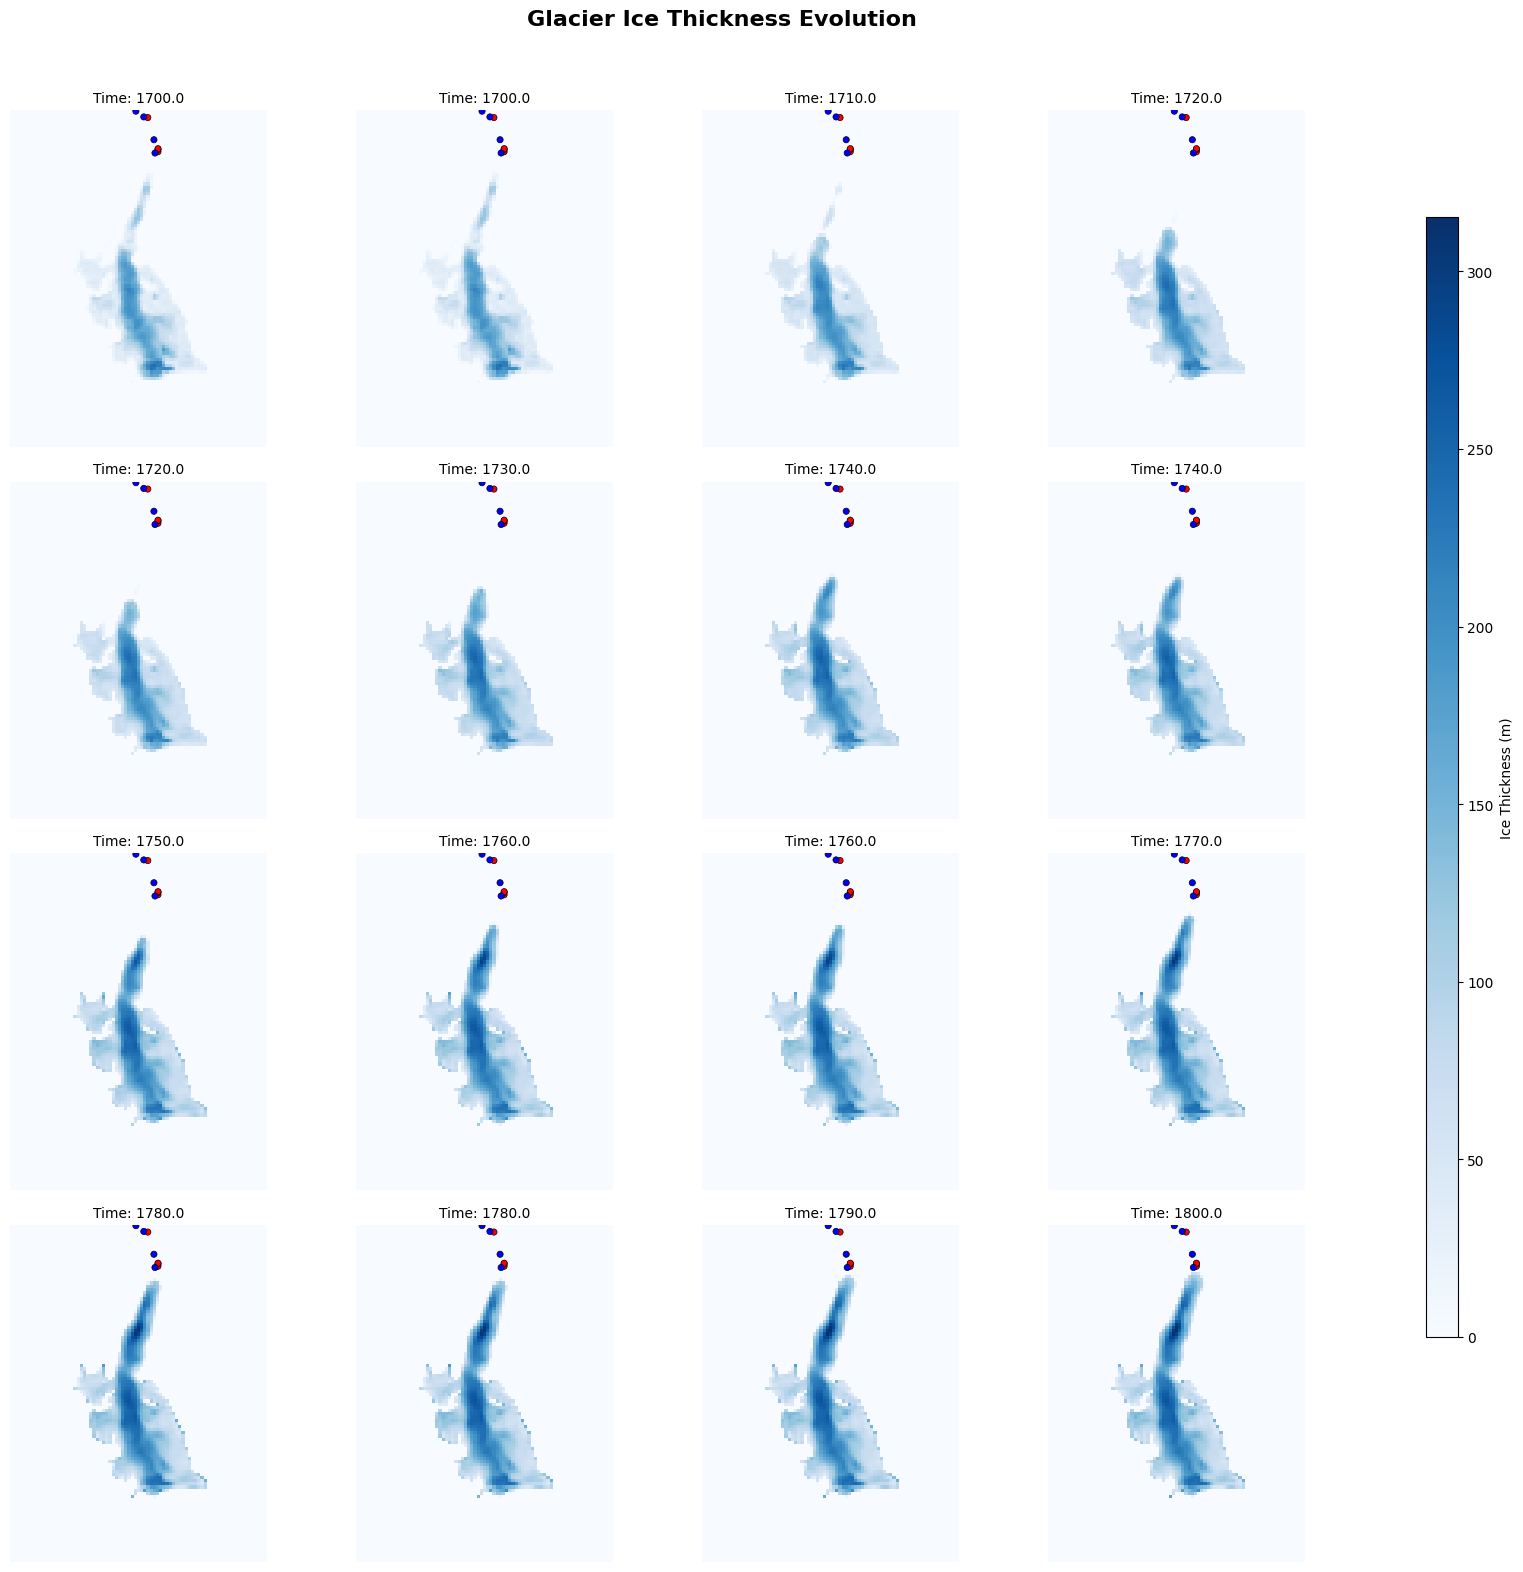

In [55]:
import importlib
import helper
importlib.reload(helper)
from helper import *
import glob

# Find all output files
output_files = sorted(glob.glob('outputs/*/*/output.nc'))

if output_files:
    print(f"Found {len(output_files)} output file(s). Using: {output_files[-1]}\n")
    # Visualize ice thickness evolution with sample locations
    animate_glacier_evolution(output_files[-1], variable='thk', log_scale=False, show_samples=True)
elif os.path.exists('output.nc'):
    print("Using output.nc in current directory\n")
    animate_glacier_evolution('output.nc', variable='thk', log_scale=False, show_samples=True)
else:
    print("No output.nc files found. Please run the model first.")

## Analyzing the Time Series Results

Let's examine how the glacier evolved under the climate scenario:

Found 8 time series file(s). Using: outputs/2025-12-02/10-00-24/output_ts.nc

Reading time series data from: outputs/2025-12-02/10-00-24/output_ts.nc



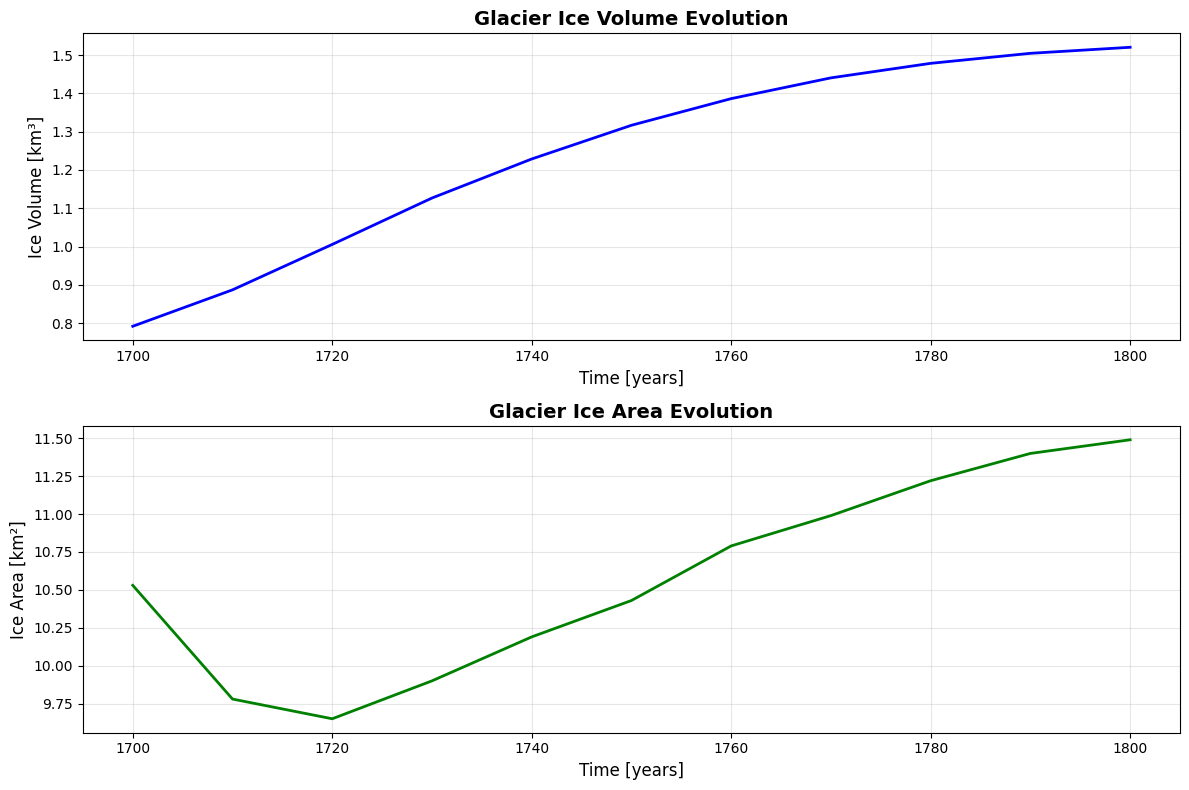


SUMMARY STATISTICS

Ice Volume:
  Initial: 0.79 km³
  Final:   1.52 km³
  Change:  0.73 km³

Ice Area:
  Initial: 10.53 km²
  Final:   11.49 km²
  Change:  0.96 km²


In [56]:
from helper import analyze_time_series
import glob

# Find time series files
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    analyze_time_series(ts_files[-1])
elif os.path.exists('output_ts.nc'):
    analyze_time_series('output_ts.nc')
else:
    print("No output_ts.nc file found.")

## Glacier Velocity Evolution

Now let's visualize the ice velocity magnitude evolution in log scale. This shows the flow dynamics and where the glacier is moving fastest.

Found 8 output file(s). Using: outputs/2025-12-02/10-00-24/output.nc



/content/glamod/04_notebook/helper.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


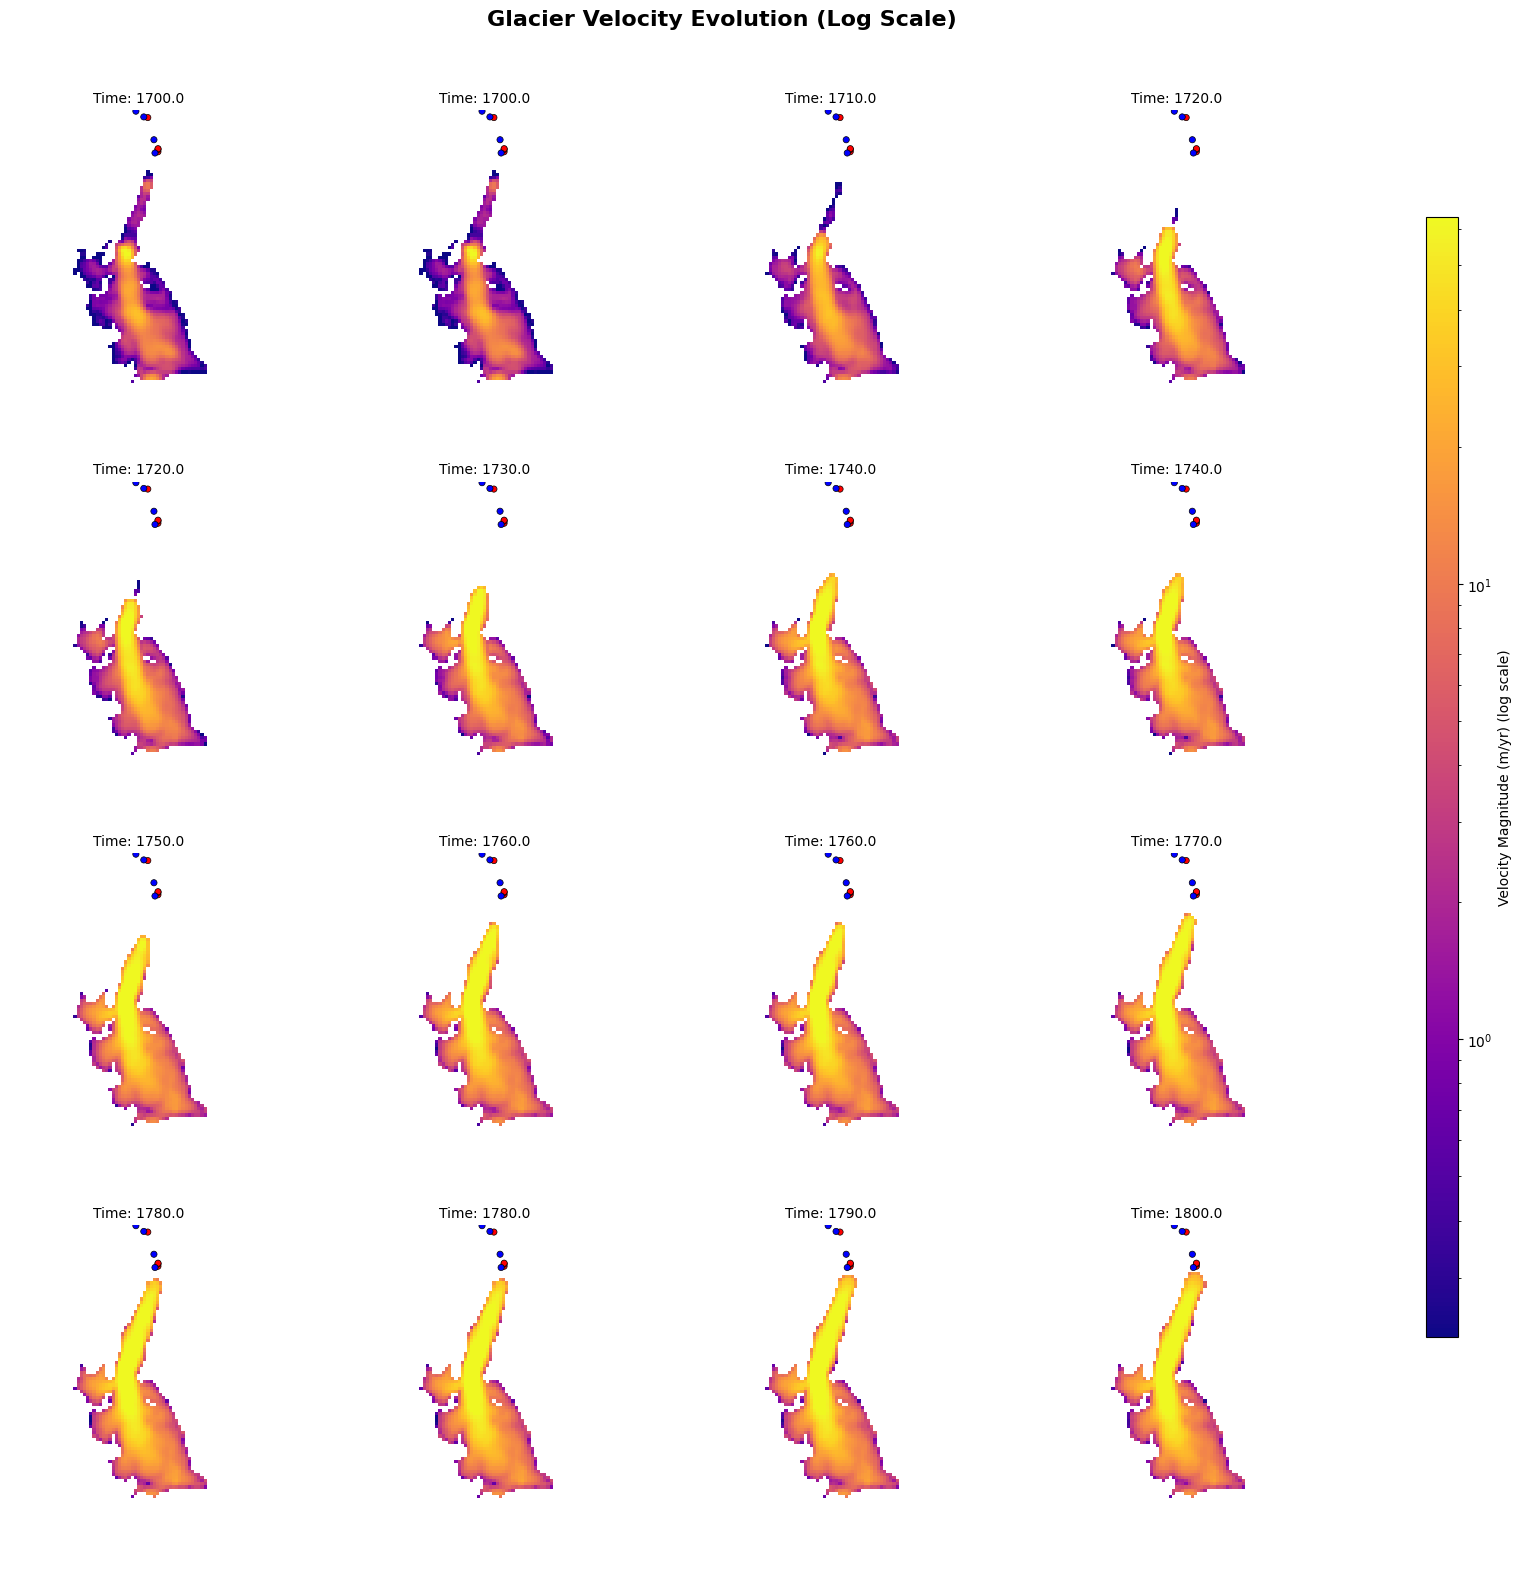

In [57]:
from helper import animate_glacier_evolution
import glob

# Find all output files
output_files = sorted(glob.glob('outputs/*/*/output.nc'))

if output_files:
    print(f"Found {len(output_files)} output file(s). Using: {output_files[-1]}\n")
    # Visualize velocity evolution with sample locations
    animate_glacier_evolution(output_files[-1], variable='velbar_mag', log_scale=True, show_samples=True)
elif os.path.exists('output.nc'):
    print("Using output.nc in current directory\n")
    animate_glacier_evolution('output.nc', variable='velbar_mag', log_scale=True, show_samples=True)
else:
    print("No output.nc files found. Please run the model first.")

Now, we can visualize the time evolution of the modelled ice thickness at the location of each samples using the following plot.

Found 8 output file(s). Using: outputs/2025-12-02/10-00-24/output.nc



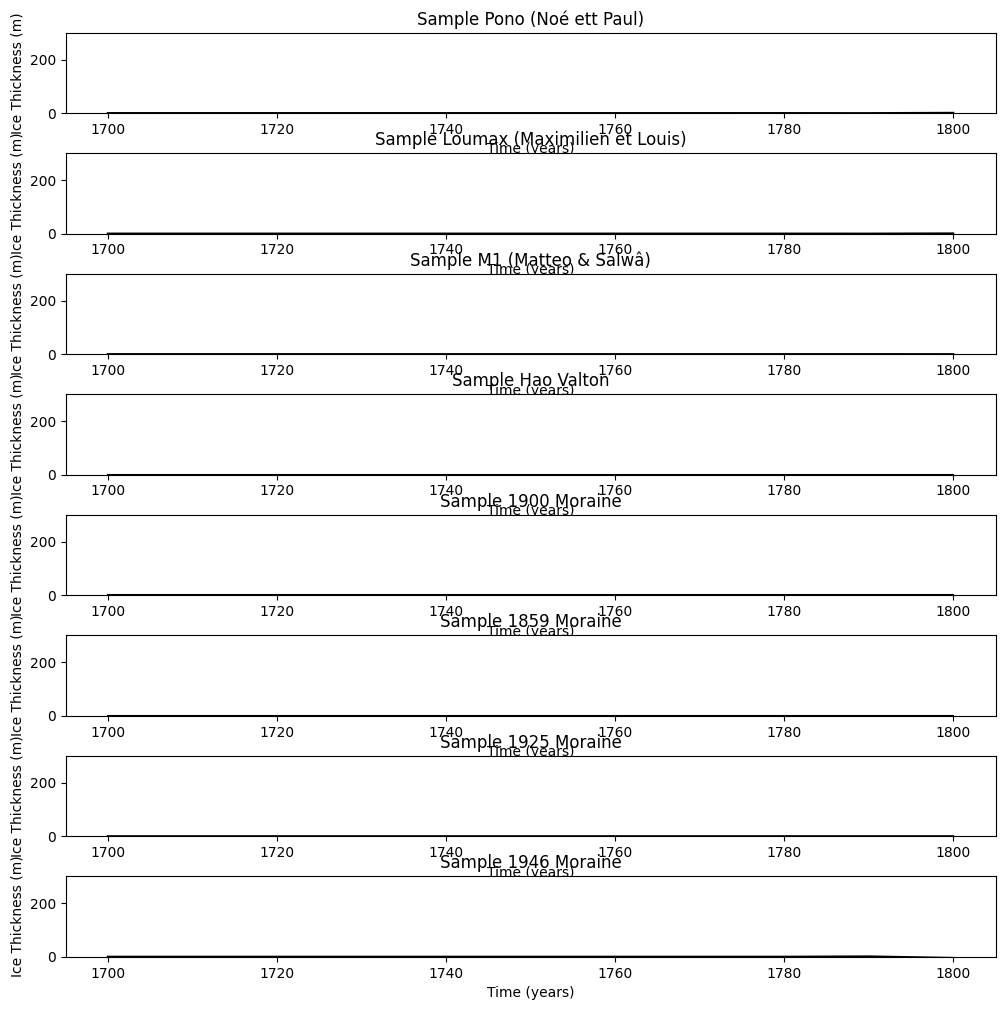

In [58]:
from helper import *
import glob

# Find all output files
output_files = sorted(glob.glob('outputs/*/*/output.nc'))

if output_files:
    print(f"Found {len(output_files)} output file(s). Using: {output_files[-1]}\n")
    plot_thk_at_sample(output_files[-1])
elif os.path.exists('output.nc'):
    print("Using output.nc in current directory\n")
    plot_thk_at_sample('output.nc')
else:
    print("No output.nc files found. Please run the model first.")

Modify the parameters in `yaml.json` as follows (tips: you may use a copy -- e.g. `params_0.yaml` -- to keep experimenting without losing the original setup):

- Change the SMB parameters: initially adjust the ELA values over time, and later consider modifying the mass balance gradients and maximum accumulation values.
- Set the parameter "iflo_init_slidingco" to a higher value (e.g., 0.4 for less basal sliding) and a lower value (e.g., 0.1 for more basal sliding).

After making these changes, observe how they affect the glacier, and attempt to align the model (by changing iteratively parameters) with the ages of the collected samples.

## To go further : using a **true** Surface Mass Balance Model

As we did in notebook 2, you may replace the simple Surface Mass Balance (SMB) model with an improved model known as the [Positive Degree Day Model (PDD)](https://www.antarcticglaciers.org/glaciers-and-climate/numerical-ice-sheet-models/modelling-glacier-melt/).